# Movie_Review

___
___

## Index
1. Loading Library
2. Define Function
3. DataSet
    - 문제점
3. Convolution 1D Model
4. With Word2Vec Model
회고
 - 내용정리
___


## Loading Library

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import sys
import os

from konlpy.tag import Mecab
from collections import Counter

plt.style.use('seaborn')

## Define Function

In [2]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## DataSet

In [3]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

# Label is sentiment class; '1' means positive, '0' does not
print(train_data.shape, test_data.shape)
train_data.head()

(150000, 3) (50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


Each sentiment class is sampled equally  

The negatives are in <font size='2dp' color='red'>___ratings 1-4 : 0___ </font>

The positives are in <font size='2dp' color='red'>___ratings 9-10 : 1___ </font>

Others are excluded

_from : https://github.com/e9t/nsmc_

___

### 문제점

In [4]:
train_data.iloc[2]

id                   10265843
document    너무재밓었다그래서보는것을추천한다
label                       0
Name: 2, dtype: object


위 예와 같이 별점은 낮게 주면서 반어법을 통해 비꼬는 review도 자주 등장할 것이라 예상된다.  

___

In [5]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # Remove from Duplicates and Not a Number Value
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # Remove from Stopwords
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if word not in stopwords] 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if word not in stopwords] 
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [6]:
if "" in word_to_index:
    del word_to_index[""]

In [7]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])
print(word_to_index['the'])
print(index_to_word[1909])

<BOS>
1909
the


In [8]:
len(word_to_index)  

10000

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

len(X_train), len(X_test)

(146182, 49157)

In [12]:
# paddding = 'pre'
x_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

## Convolution 1D Model

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [14]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=2048,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
67/67 [==============================] - 4s 12ms/step - loss: 0.6409 - accuracy: 0.6725 - val_loss: 0.4809 - val_accuracy: 0.8028
Epoch 2/20
67/67 [==============================] - 0s 7ms/step - loss: 0.3892 - accuracy: 0.8325 - val_loss: 0.3522 - val_accuracy: 0.8431
Epoch 3/20
67/67 [==============================] - 0s 7ms/step - loss: 0.3270 - accuracy: 0.8613 - val_loss: 0.3438 - val_accuracy: 0.8511
Epoch 4/20
67/67 [==============================] - 0s 7ms/step - loss: 0.3047 - accuracy: 0.8723 - val_loss: 0.3411 - val_accuracy: 0.8530
Epoch 5/20
67/67 [==============================] - 0s 7ms/step - loss: 0.2890 - accuracy: 0.8807 - val_loss: 0.3390 - val_accuracy: 0.8521
Epoch 6/20
67/67 [==============================] - 0s 7ms/step - loss: 0.2758 - accuracy: 0.8870 - val_loss: 0.3399 - val_accuracy: 0.8539
Epoch 7/20
67/67 [==============================] - 0s 7ms/step - loss: 0.2616 - accuracy: 0.8939 - val_loss: 0.3442 - val_accuracy: 0.8509
Epoch 8/20
67/67 [=

In [16]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


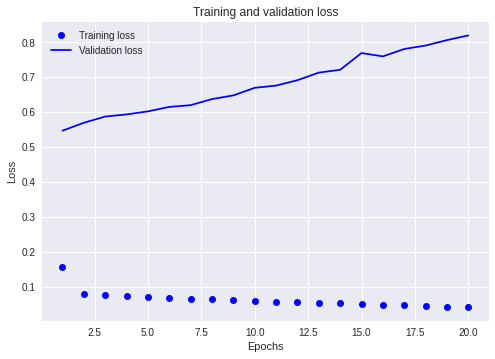

In [30]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## With Word2Vec Model

In [18]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [19]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.05636433, -0.09343188, -0.10750367, -0.04793426,  0.1444318 ,
        0.07887366,  0.03443504,  0.05094593, -0.06381337,  0.03233023,
        0.06317201,  0.0255695 ,  0.07179599, -0.0964842 ,  0.07453474,
        0.00864206], dtype=float32)

In [21]:
word_vectors.similar_by_word("사랑")

[('ㅠㅜ', 0.9436976313591003),
 ('열혈', 0.9292166829109192),
 ('굿', 0.9169647693634033),
 ('배출', 0.9114456176757812),
 ('바람직', 0.9081238508224487),
 ('검술', 0.9059687852859497),
 ('탁월', 0.903371274471283),
 ('누군가', 0.9033442735671997),
 ('최고', 0.9018039703369141),
 ('두근거리', 0.9005314707756042)]

In [24]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [25]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [26]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [40]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [34]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=1024,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
133/133 [==============================] - 2s 13ms/step - loss: 0.0558 - accuracy: 0.9829 - val_loss: 0.9569 - val_accuracy: 0.8105
Epoch 2/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0297 - accuracy: 0.9918 - val_loss: 1.0149 - val_accuracy: 0.8087
Epoch 3/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0280 - accuracy: 0.9926 - val_loss: 1.0672 - val_accuracy: 0.8077
Epoch 4/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0271 - accuracy: 0.9929 - val_loss: 1.1222 - val_accuracy: 0.8071
Epoch 5/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0264 - accuracy: 0.9929 - val_loss: 1.1072 - val_accuracy: 0.8072
Epoch 6/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0254 - accuracy: 0.9933 - val_loss: 1.1707 - val_accuracy: 0.8056
Epoch 7/20
133/133 [==============================] - 2s 12ms/step - loss: 0.0253 - accuracy: 0.9931 - val_loss: 1.2143 - val_accuracy: 0.8028

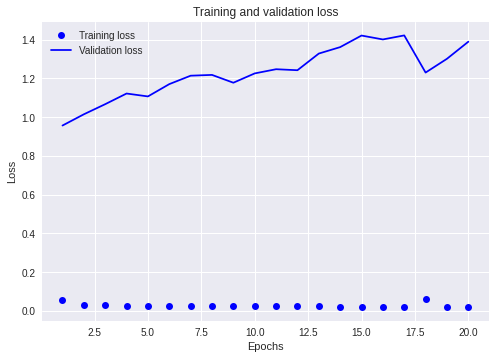

In [35]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

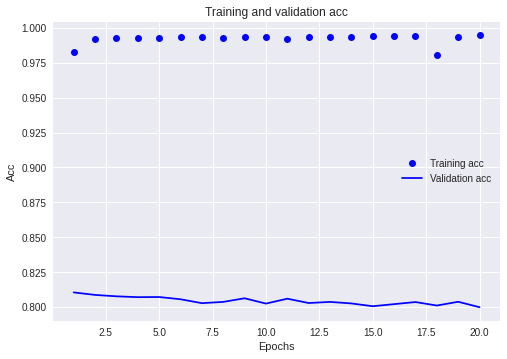

In [38]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

In [ ]:
vocab_size = 10000
word_vector_dim = 300

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

___
___

# 회고

## 내용정리
___

<img src='http://t1.daumcdn.net/cfile/206075184B1F737958'></img>

<del>이걸 못피했네</del>  


# Sentiment Analysis
## Padding
```
tf.keras.preprocessing.sequence.pad_sequences(inputs,
value=word_to_index['<PAD>'],
padding='post', maxlen=5) # return sequence padded
```

_학습시키기 전에 train data, test data 모두 반드시 처리_

### Max length of words

__표준정규분포표를 활용하자__
https://ko.wikipedia.org/wiki/%ED%91%9C%EC%A4%80%EC%A0%95%EA%B7%9C%EB%B6%84%ED%8F%AC%ED%91%9C

데이터가 표준정규분포를 따르지 않을 것이지만, 비율을 결정할 때 수치상의 도움을 줄 수 있다.

### Post, Pre

padding = 'post' or 'pre'

일반적으로 pre가 성능이 좋은 것으로 알려져있다.

가장 마지막 입력이 큰 영향을 미치는데 이 값이 의미없는 패딩값보다는 의미 있는 값으로 되어야 한다.
## Embedding
```
# vocab_size; the number of vocabulary in a dictionary
vocab_size = len(word_to_index)

# a dimension by which words represent vector shape
# in other words, we express the words into digits
word_vector_dim = 4 

tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_shape=(None, ), mask_zero=True)
# return embedding layer
```
_비슷한 문맥에서 자주 등장하는 단어들은 비슷한 위치에 위치시키도록 함_

### outputs
___outputs.shape___
```
# Embedding Layer
outputs = embedding(inputs)
print(outputs.shape)
```
입력문장의 개수, 입력문장의 최대 길이, 임베딩 차원

## Dataset

https://keras.io/api/datasets/imdb/

tensorflow.keras.datasets.imdb

### load_data Function
```
tf.keras.datasets.imdb.load_data(
    path="imdb.npz",
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3,
    **kwargs
)
```

_return (x_train, y_train), (x_test, y_test)_

### get_word_index Function

_return a dictionary mapping words to index_